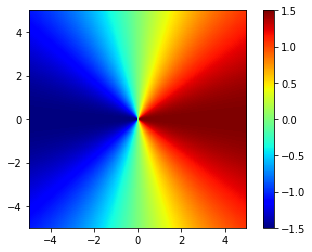

In [19]:
import numpy as np
from matplotlib import pyplot as plt

def gauss_2d(x, y, spar):
    '''
    spar[0]: Normalization [1]:xcenter [2]:ycenter [3]:effective radius 
    '''
    (xnew, ynew)=(x-spar[1],y-spar[2])
    r=np.sqrt(xnew**2.+ynew**2.)
    return spar[0]*np.exp(-0.5*(r/spar[3])**2)

def xy_transform(x, y, x_cen, y_cen, phi):
    '''
    A clockwise-rotationl Matrix
    '''
    xnew=(x-x_cen)*np.cos(np.pi*phi/180.0)+(y-y_cen)*np.sin(np.pi*phi/180.0)
    ynew=-(x-x_cen)*np.sin(np.pi*phi/180.0)+(y-y_cen)*np.cos(np.pi*phi/180.0)
    return (xnew, ynew)

def sersic_2d(x, y, spar):
    '''
    spar[0]: Intensity at r_eff  [1]:xcnter  [2]:ycenter  [3]:r_eff 
    [4]:PA  [5]:axis_ratio   [6]:sersic index
    '''
    (xnew, ynew)=xy_transform(x, y, spar[1], spar[2], spar[4])
    n=spar[6]
    if n >= 0.36: # from Ciotti & Bertin 1999, truncated to n^-3
        k=2.0*n-1./3+4./(405.*n)+46./(25515.*n**2.)+131./(1148175.*n**3.)
    else: # from MacArthur et al. 2003
        k=0.01945-0.8902*n+10.95*n**2.-19.67*n**3.+13.43*n**4.
    r=np.sqrt(spar[5]*xnew**2.+ynew**2./spar[5])
    return spar[0]*np.exp(-k*((r/spar[3])**(1./n)-1.0))

def def_sis(x, y, lpar):
    '''
    Calculating the deflection angle of an SIS mass profile following Kormann 1993
    0:Einstein radius 1:xcenter  2:ycenter  
    '''
    (xnew, ynew)=(x-lpar[1],y-lpar[2])
    r_sie=np.sqrt(xnew**2.+ynew**2.)
    alpha_x=xnew/(r_sie+(r_sie==0))
    alpha_y=ynew/(r_sie+(r_sie==0))
    return (lpar[0]*alpha_x, lpar[0]*alpha_y)

def add_noise(image,skylevel,exposure):
    image_= image + skylevel
    counts = image_ * exposure
    counts = np.random.poisson(counts, image_.shape)
    image = counts*1.0/exposure - skylevel
    return image



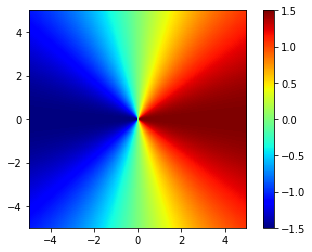

In [25]:
#lens test
lpar = [1.5, 0.0, 0.0]
hw = 100
dpix = 0.05
xcoord = np.arange(-hw,hw+1)*dpix
ycoord = np.arange(-hw,hw+1)*dpix
xcoord,ycoord = np.meshgrid(xcoord,ycoord)


deflx,defly = def_sis(xcoord, ycoord, lpar)

visual_kwgs = {'origin':'lower','extent':[xcoord.min(),xcoord.max(),ycoord.min(),ycoord.max()],'cmap':'jet'}
plt.imshow(deflx,**visual_kwgs)
plt.colorbar()
plt.show()

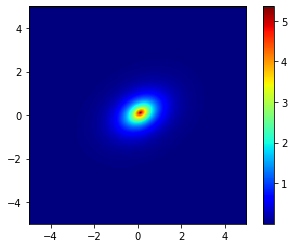

In [24]:
#light test
spar = [1.0, 0.1, 0.1, 0.8, 30.0, 0.7, 1.0]
light = sersic_2d(xcoord,ycoord,spar)

visual_kwgs = {'origin':'lower','extent':[xcoord.min(),xcoord.max(),ycoord.min(),ycoord.max()],'cmap':'jet'}
plt.imshow(light,**visual_kwgs)
plt.colorbar()
plt.show()

In [3]:
import torch
import torch.optim as optim
import torch.nn as nn
#from torchviz import make_dot
class generate_lensed_image(nn.Module):
    def __init__(self):
        super().__init__()
        self.lpar = nn.Parameter(torch.tensor([1., 0.0, 0.0],requires_grad=True, dtype=torch.float))
        self.spar = nn.Parameter(torch.tensor([0.2, 0.0, 0.0, 1.0],requires_grad=True, dtype=torch.float))
        
    def gauss_2d(self, x, y, spar):
        '''
        spar[0]: Normalization [1]:xcenter [2]:ycenter [3]:effective radius 
        '''
        (xnew, ynew)=(x-spar[1],y-spar[2])
        r=torch.sqrt(xnew**2.+ynew**2.)
        return spar[0]*torch.exp(-0.5*(r/spar[3])**2)
    
    def def_sis(self, x, y, lpar):
        '''
        Calculating the deflection angle of an SIS mass profile following Kormann 1993
        0:Einstein radius 1:xcenter  2:ycenter  
        '''
        (xnew, ynew)=(x-lpar[1],y-lpar[2])
        r_sie=torch.sqrt(x**2.+y**2.)
        alpha_x=xnew/(r_sie+(r_sie==0))
        alpha_y=ynew/(r_sie+(r_sie==0))
        return (lpar[0]*alpha_x, lpar[0]*alpha_y)
    
    def add_noise(self, image, skylevel, exposure):
        image = image.detach().numpy() 
        image_= image + skylevel
        counts = image_ * exposure
        counts = np.random.poisson(counts, image_.shape)*1.0
        counts = torch.from_numpy(counts)
        counts.requires_grad_()
        image = counts*1.0/exposure - skylevel
        return image
       
    def forward(self, x, y, skylevel,exposure):
        # Computes the outputs / predictions
        deflx,defly = self.def_sis(x, y, self.lpar)
        lensed_data = self.gauss_2d(x-deflx,y-defly,self.spar)
        #lensed_data = self.add_noise(lensed_data,skylevel,exposure)
        return lensed_data


In [4]:
x = torch.from_numpy(xcoord)
y = torch.from_numpy(ycoord)
data = torch.from_numpy(Mock)
# Now we can create a model and send it at once to the device
model = generate_lensed_image()
# We can also inspect its parameters using its state_dict
print(model.state_dict())

lr = 1e-1
n_epochs = 10000

loss_fn = nn.MSELoss(reduction='mean')
optimizer = optim.SGD(model.parameters(), lr=lr)

for epoch in range(n_epochs):
    # What is this?!?
    model.train()

    # No more manual prediction!
    # yhat = a + b * x_tensor
    yhat = model(x,y,0.5,500.0)
    
    loss = loss_fn(data, yhat)
    loss.backward()    
    optimizer.step()
    optimizer.zero_grad()

print(model.state_dict())

OrderedDict([('lpar', tensor([1., 0., 0.])), ('spar', tensor([0.2000, 0.0000, 0.0000, 1.0000]))])
OrderedDict([('lpar', tensor([1.4994, 0.0000, 0.0000])), ('spar', tensor([1.0002, 1.0001, 0.4008, 0.1999]))])


#### Todo
Short aim(nextweek)
- PSF convolution
- elliptical lens/source
- add poisson and gaussian noise?
- code refactor

Middle aim(this month)
- irregular source light model
- baeysian sampling(Pyro,Polynest?)